In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

The manual method I currently use (10/23/2025) brute forces the active-fraction (AF) histogram calculation by using the photon-count histogram with a same shape ones array. I looping through each time bin by subtracting out "n" deadtime bins after each bin that contains detections, scaled by the number of detections in the bin. Then normalize based on bin size and integrated shots. This method works but is pretty slow due to the for loops involved.

A quicker method suggested by Matt is to copy the photon-count histogram and perform a convolution using a "deadtime" kernel. This will look like ones (or zeros) that correspond to the number of bins that occupy the deadtime interval. To include fractional binning, I can add a fractional value at the end of the kernel that corresponds to partial overlap of deadtime in the last bin. 

An example is provided below. If the range binsize $\Delta t_r$ is 1 m, and the deadtime $\tau$ is 4.5 m, then a deadtime kernel would look like this:

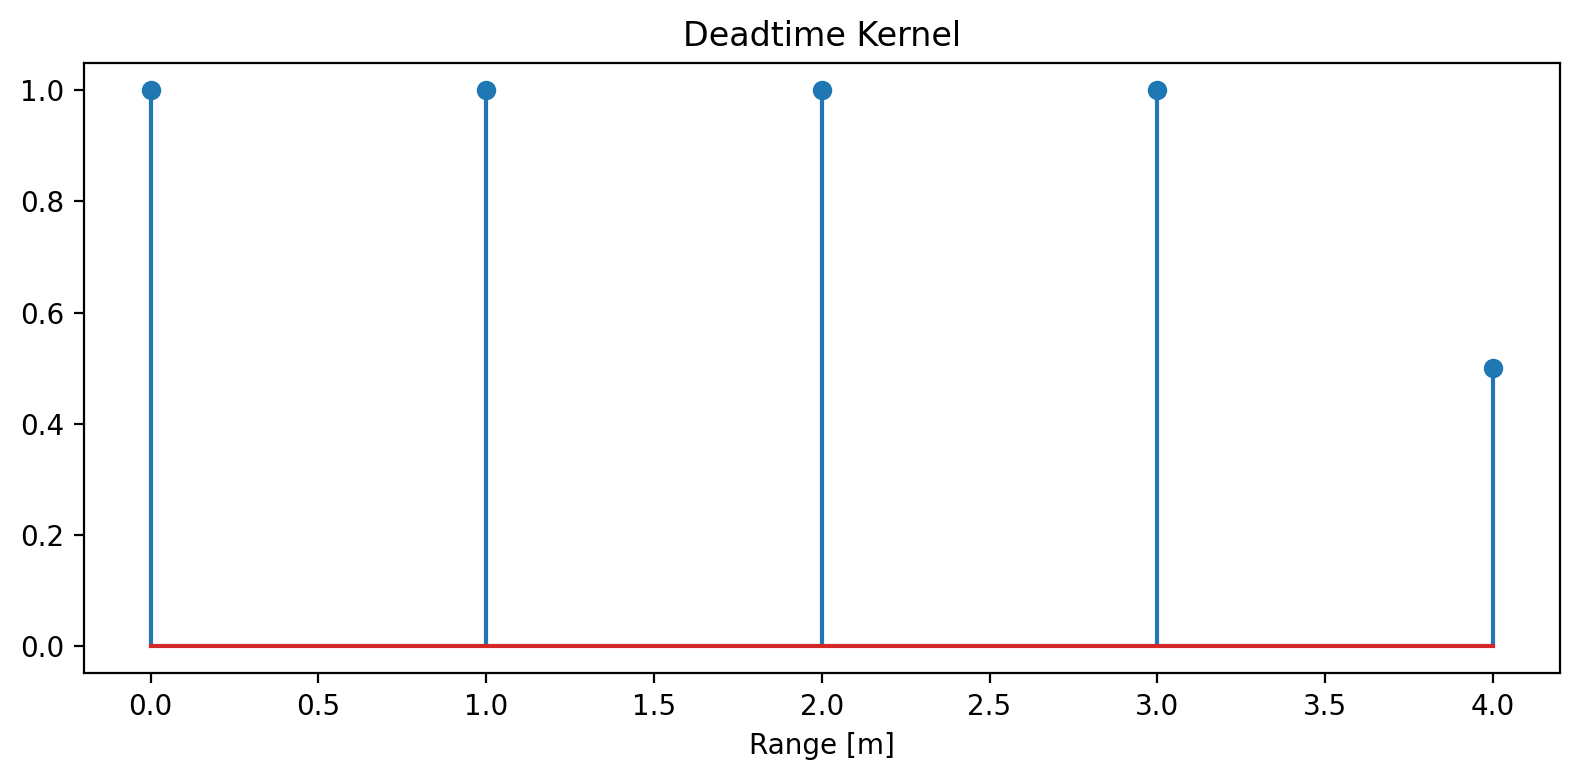

In [2]:
dkern = np.array([1, 1, 1, 1, 0.5])
r = np.arange(0, len(dkern))  # [m]

fig = plt.figure(dpi=200, 
                 figsize=(8, 4)
                )
ax = fig.add_subplot(111)
ax.stem(r, dkern, use_line_collection=True)
ax.set_xlabel('Range [m]')
ax.set_title('Deadtime Kernel')
plt.tight_layout()
plt.show()

If I have a 1D range photon-count histogram $y[r]$, then the "dead-fraction" histogram $d[r]$ will be the convolution of the deadtime kernel $d_K[k]$ and the photon-count histogram, or 
$$d[r]=y[r]\ast d_K[k],$$
where $r$ is the discrete range index and $k$ is the discrete kernel index. 
The normalized dead-fraction histogram is found by dividing by the number of accumulated shots $N$. Then, the active-fraction histogram $a[r]$ is found by subtracting from 1:
$$a[r]=1-\frac{d[r]}{N}.$$

An example of this is tested below. At first, I do not implement fractional binning, where partial overlap of deadtime produces a fractional value in the kernel. The first example I provide is on a dirac delta signal. Then it is applied to a uniform signal.

In [140]:
c = 3.0e8  # [m/s]
deadtime = 29.1e-9  # [s]
rbinsize = 0.7  # [m]

K = np.floor((deadtime * c / 2) / rbinsize).astype(int)  # number of bins (floor round) that occupy deadtime
dtime_kern = np.ones(K)

N = 10  # number of shots
min_range = 0  # [m]
max_range = 20  # [m]
ranges = np.arange(min_range, max_range + rbinsize, rbinsize)
nrbins = len(ranges)  # number of elements

y = np.zeros(nrbins)
y[nrbins // 2] = N

d = fftconvolve(y, dtime_kern, mode='full') / N
d = d[:nrbins]
a = 1 - d

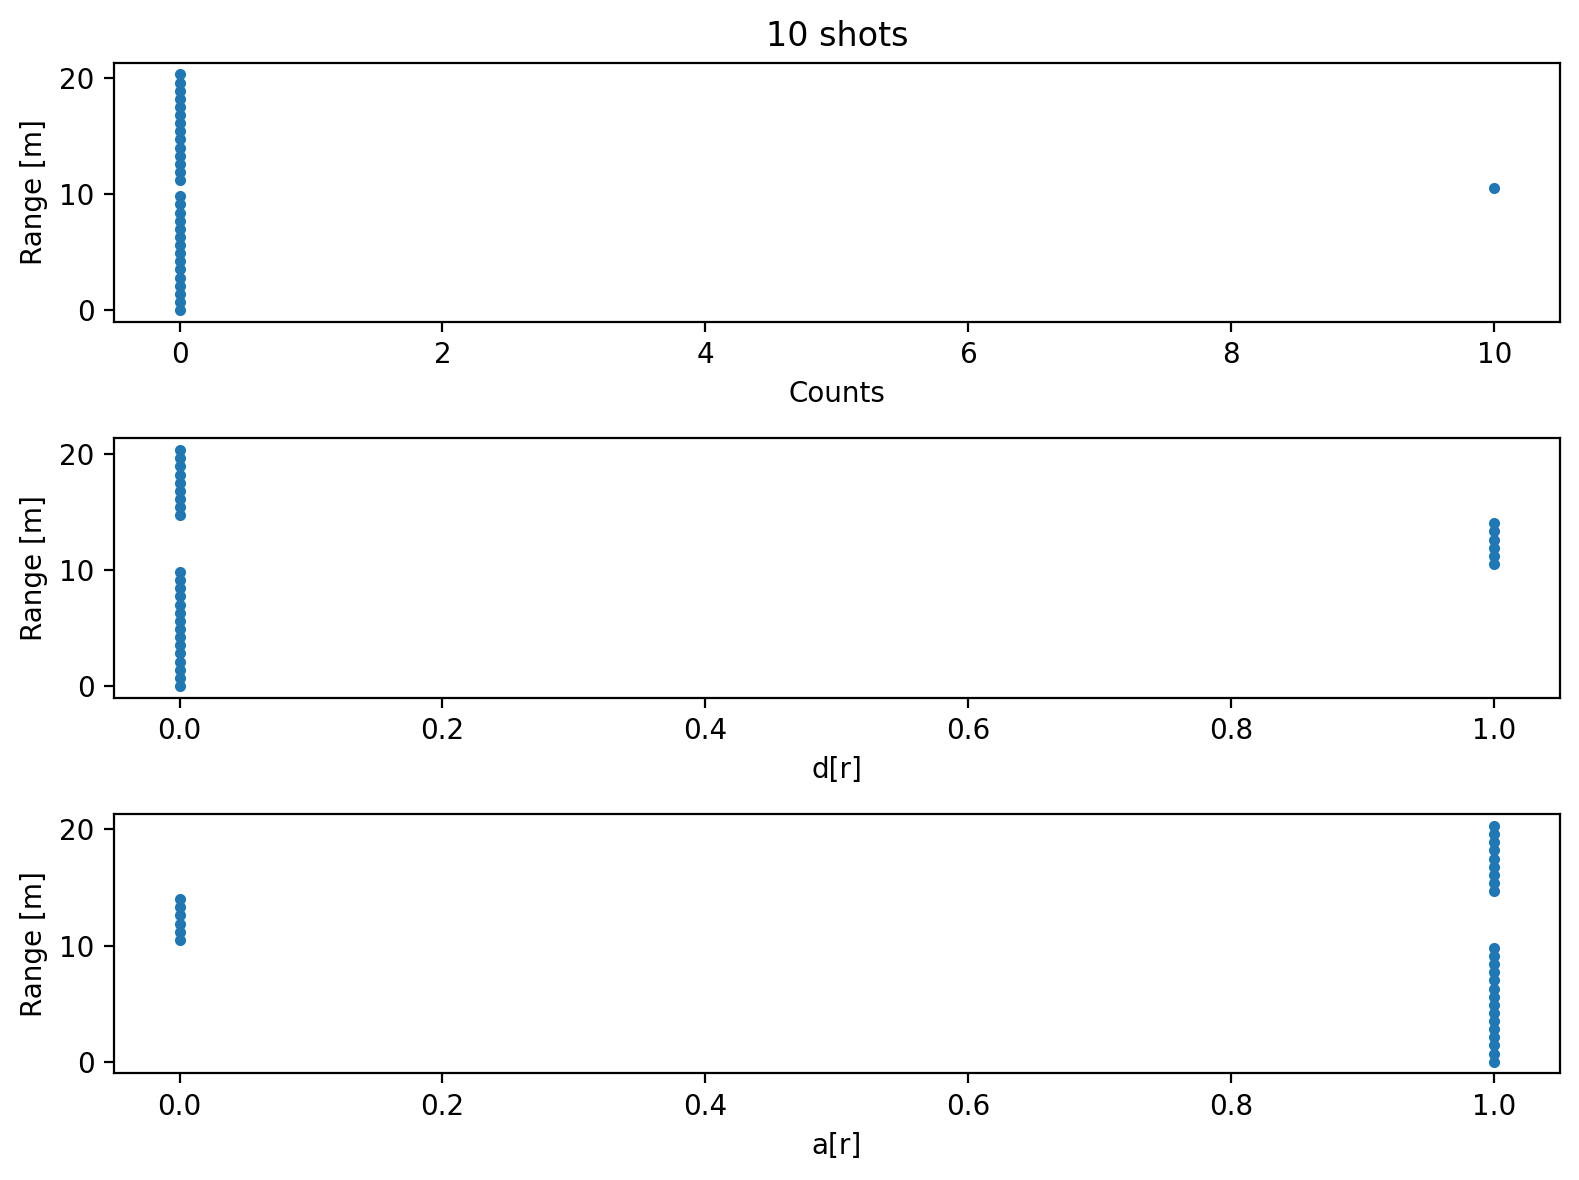

In [141]:
fig = plt.figure(dpi=200,
                 figsize=(8, 6)
                )

ax1 = fig.add_subplot(311)
ax1.plot(y, ranges, '.')
ax1.set_xlabel('Counts')
ax1.set_ylabel('Range [m]')
ax1.set_title('{} shots'.format(N))
# ax1.set_xlim([0, 2])

ax2 = fig.add_subplot(312)
ax2.plot(d, ranges, '.')
ax2.set_xlabel('d[r]')
ax2.set_ylabel('Range [m]')
# ax2.set_xlim([0, 1])

ax3 = fig.add_subplot(313)
ax3.plot(a, ranges, '.')
ax3.set_xlabel('a[r]')
ax3.set_ylabel('Range [m]')
# ax3.set_xlim([0, 1])

plt.tight_layout()
plt.show()

In [142]:
N = 10000  # number of shots
max_cnt = N * rbinsize / 10
y = max_cnt * np.ones(nrbins)

d = fftconvolve(y, dtime_kern, mode='full') / N
d = d[:nrbins]
a = 1 - d

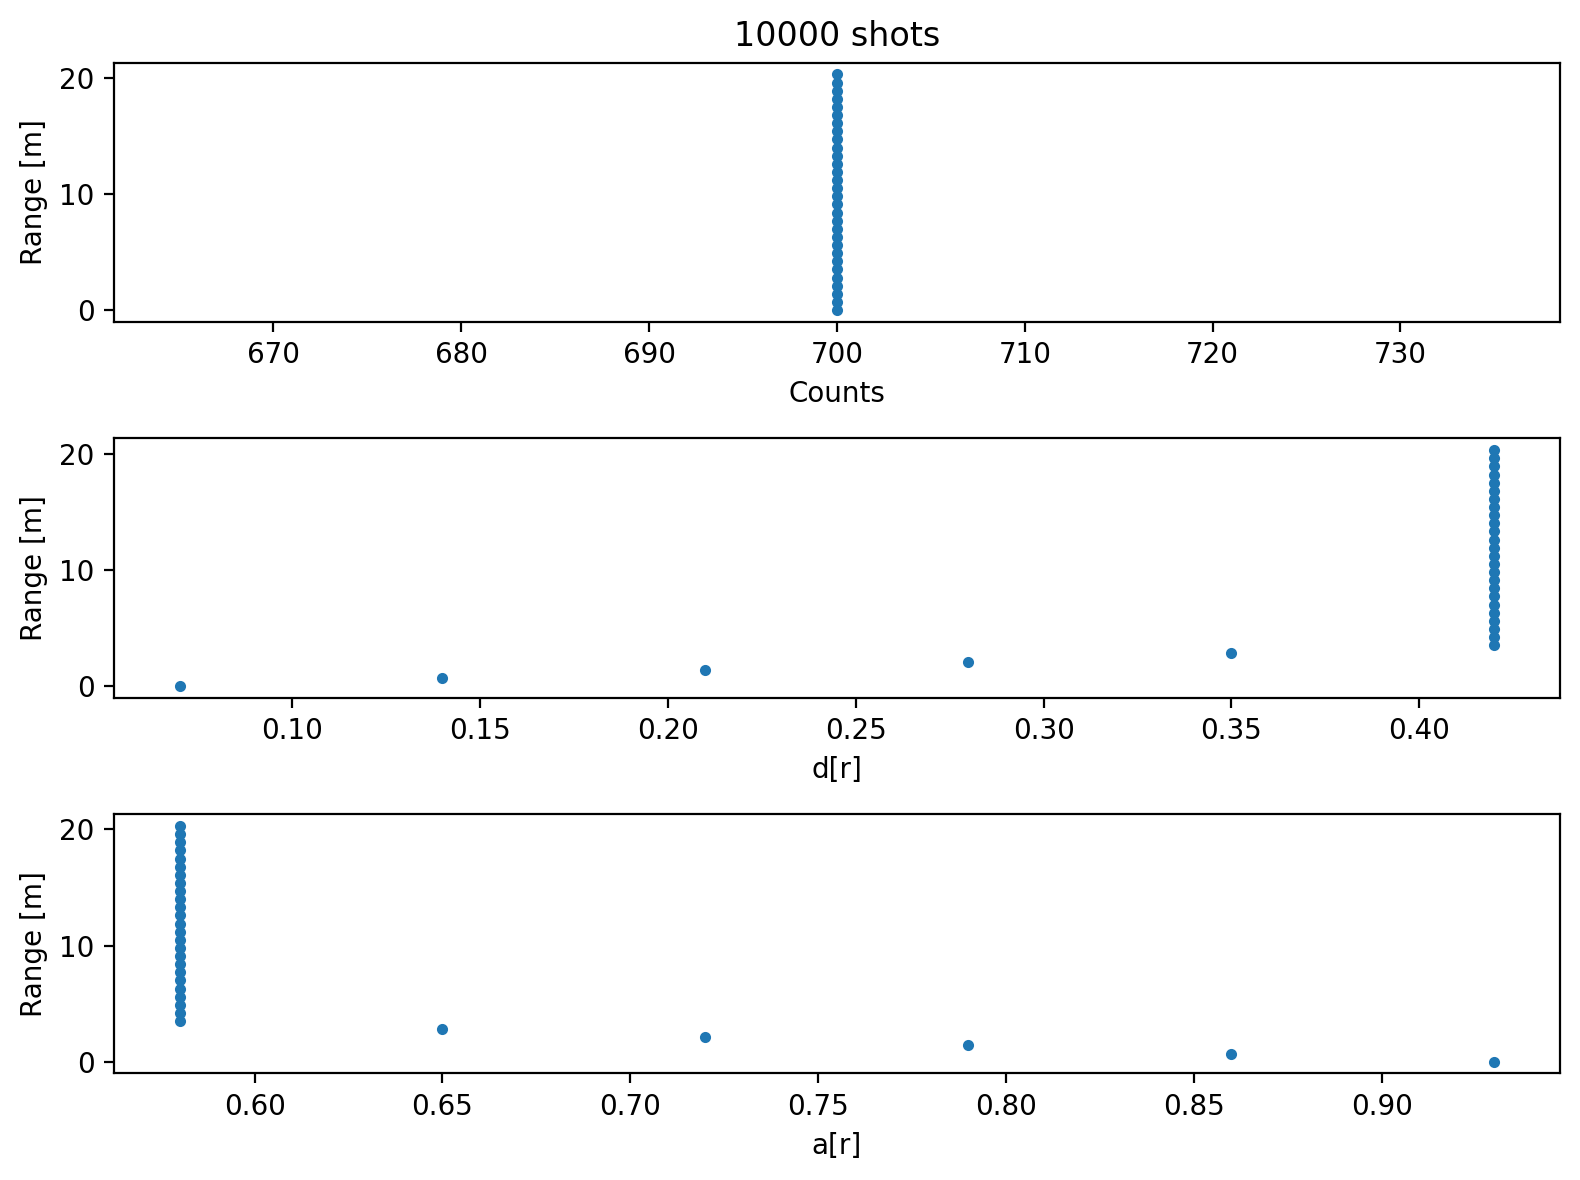

In [143]:
fig = plt.figure(dpi=200,
                 figsize=(8, 6)
                )

ax1 = fig.add_subplot(311)
ax1.plot(y, ranges, '.')
ax1.set_xlabel('Counts')
ax1.set_ylabel('Range [m]')
ax1.set_title('{} shots'.format(N))
# ax1.set_xlim([0, max_cnt])

ax2 = fig.add_subplot(312)
ax2.plot(d, ranges, '.')
ax2.set_xlabel('d[r]')
ax2.set_ylabel('Range [m]')
# ax2.set_xlim([0, 1])

ax3 = fig.add_subplot(313)
ax3.plot(a, ranges, '.')
ax3.set_xlabel('a[r]')
ax3.set_ylabel('Range [m]')
# ax3.set_xlim([0, 1])

plt.tight_layout()
plt.show()

Now it's time to add the fractional overlap of the deadtime onto a final bin. Meaning, the remainder of the division of the deadtime and the range bin size is tacked onto the deadtime kernel. 

In [144]:
remainder = (deadtime * c / 2) % rbinsize 
dtime_kern = np.append(dtime_kern, remainder)

d = fftconvolve(y, dtime_kern, mode='full') / N
d = d[:nrbins]
a = 1 - d

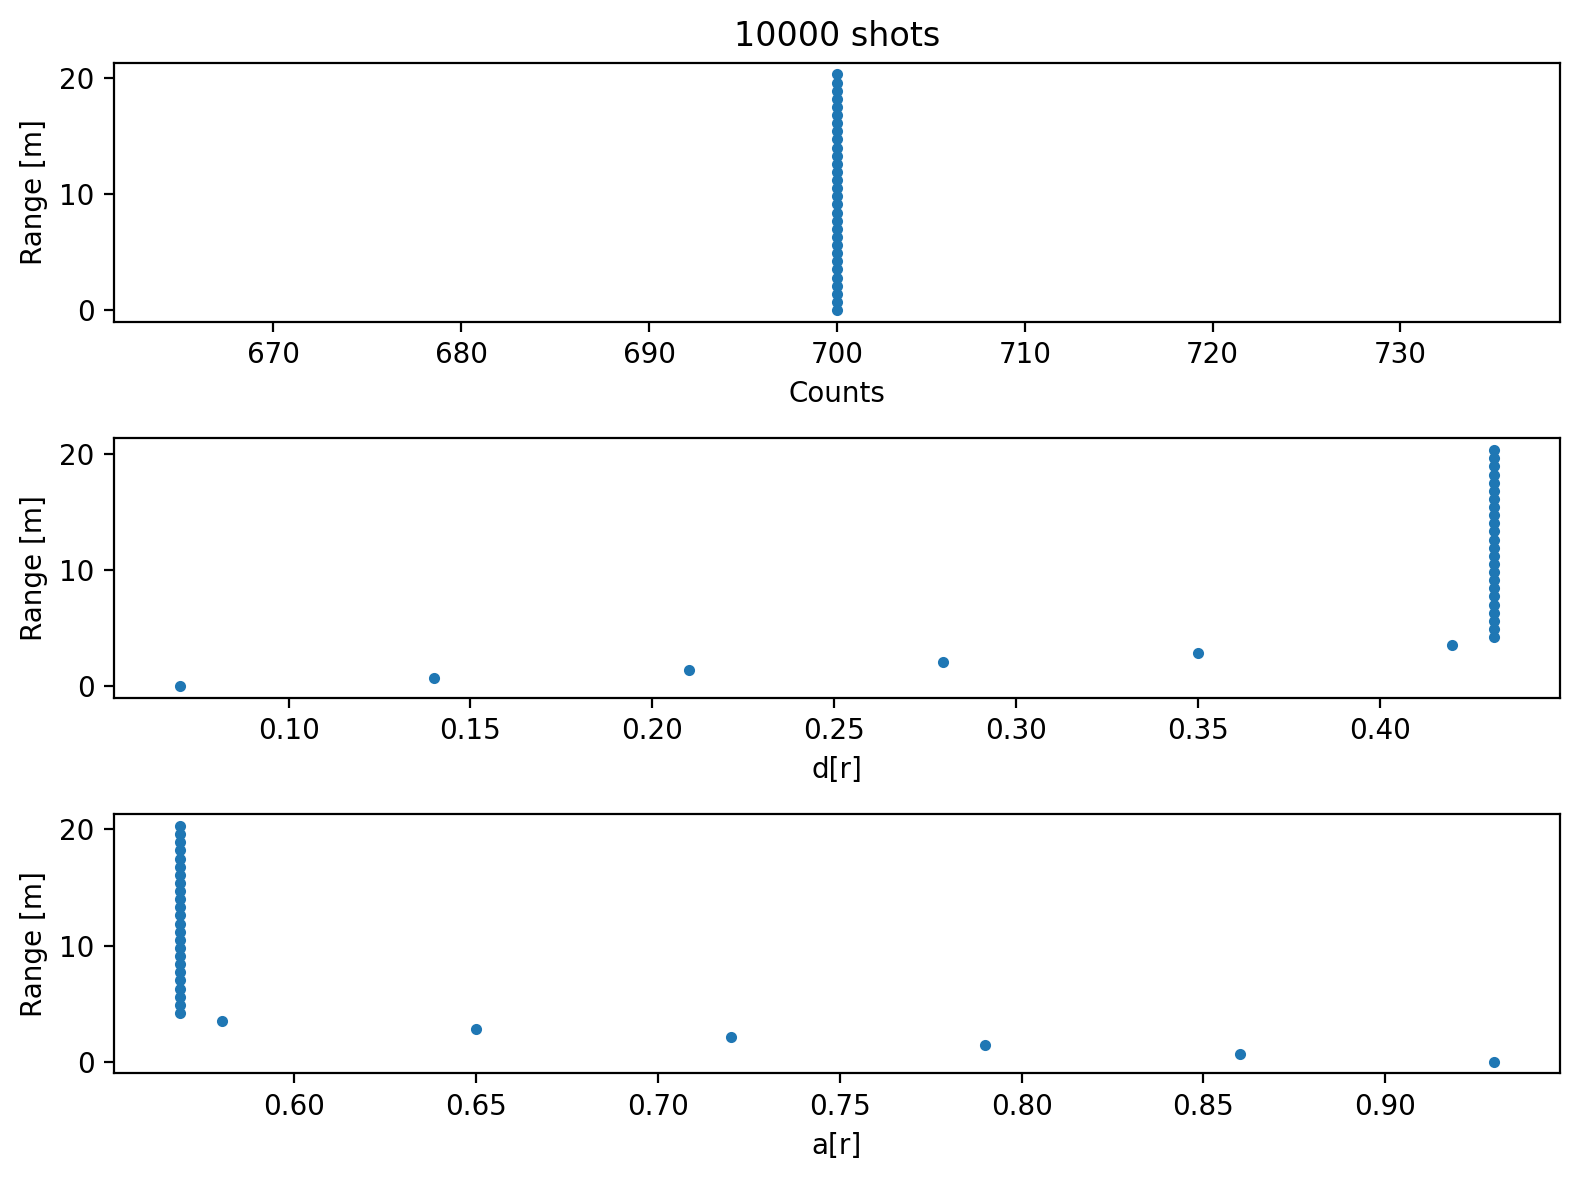

In [145]:
fig = plt.figure(dpi=200,
                 figsize=(8, 6)
                )

ax1 = fig.add_subplot(311)
ax1.plot(y, ranges, '.')
ax1.set_xlabel('Counts')
ax1.set_ylabel('Range [m]')
ax1.set_title('{} shots'.format(N))
# ax1.set_xlim([0, max_cnt])

ax2 = fig.add_subplot(312)
ax2.plot(d, ranges, '.')
ax2.set_xlabel('d[r]')
ax2.set_ylabel('Range [m]')
# ax2.set_xlim([0, 1])

ax3 = fig.add_subplot(313)
ax3.plot(a, ranges, '.')
ax3.set_xlabel('a[r]')
ax3.set_ylabel('Range [m]')
# ax3.set_xlim([0, 1])

plt.tight_layout()
plt.show()

Now let's add in the 2nd dimension (time). The kernel still only acts on the range component though. So the photon-count histogram is now $y[k, t]$, where $t$ is the discrete time index.

In [146]:
nt = 10
tbins = np.arange(0, nt + 1, 1)
ntbins = len(tbins)

# y = np.random.randint(0, max_cnt + 1, size=(nrbins, ntbins))

# # Add a region of max counts in the middle
# idx = nrbins // 2
# y[idx, :] = N * np.ones(ntbins)
# y[idx+1:idx+K, :] = 0
# y[idx-K+1:idx, :] = 0

y = np.zeros((nrbins, ntbins))
y[nrbins // 2, :] = N

d = fftconvolve(y, dtime_kern[:, None], mode='full') / N
d = d[:nrbins, :]
a = 1 - d

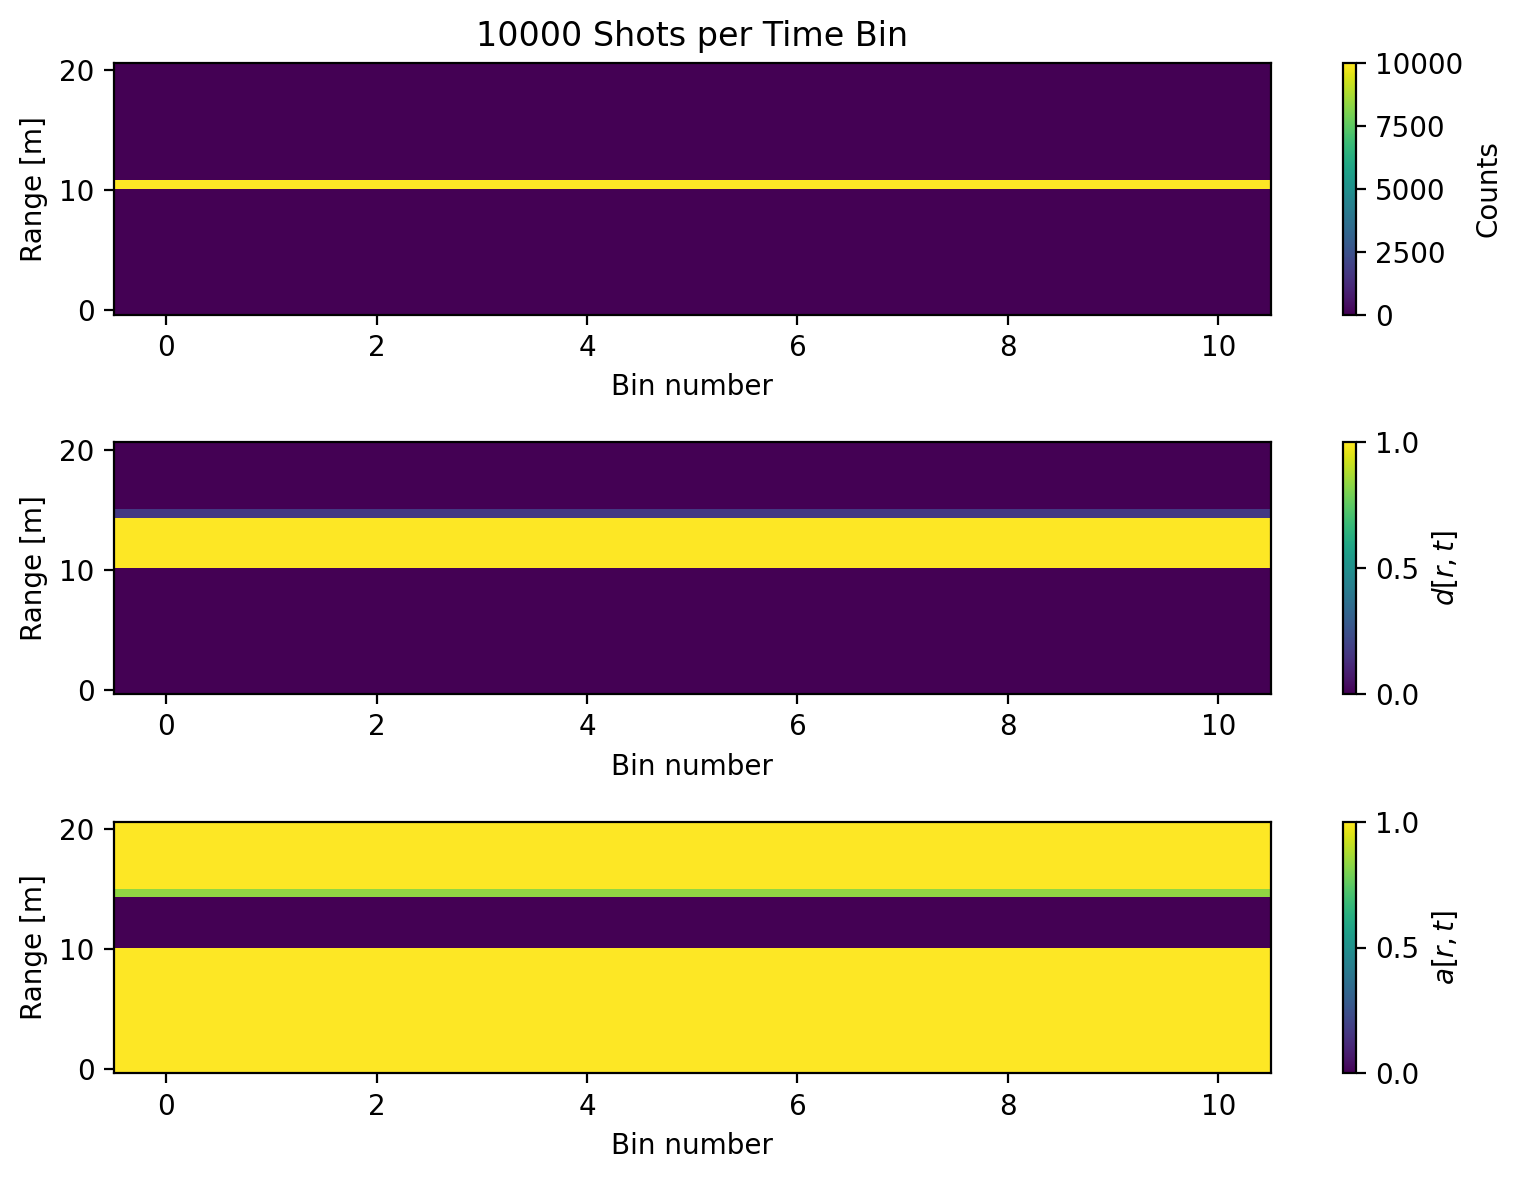

In [148]:
rbinedges = ranges - (rbinsize / 2)
rbinedges = np.append(rbinedges, rbinedges[-1] + rbinsize)
tbinedges = tbins - 0.5
tbinedges = np.append(tbinedges, tbins[-1] + 0.5)

fig = plt.figure(dpi=200, figsize=(8, 6))
ax1 = fig.add_subplot(311)
mesh1 = ax1.pcolormesh(tbinedges, rbinedges, y, vmin=y.min(), vmax=y.max())
ax1.set_xlabel('Bin number')
ax1.set_ylabel('Range [m]')
ax1.set_title('{} Shots per Time Bin'.format(N))
ax1.set_xlim([tbinedges[0], tbinedges[-1]])
ax1.set_ylim([rbinedges[0], rbinedges[-1]])
cbar1 = plt.colorbar(mesh1, ax=ax1)
cbar1.set_label('Counts')

ax2 = fig.add_subplot(312)
mesh2 = ax2.pcolormesh(tbinedges, rbinedges, d)
ax2.set_xlabel('Bin number')
ax2.set_ylabel('Range [m]')
ax2.set_xlim([tbinedges[0], tbinedges[-1]])
ax2.set_ylim([rbinedges[0], rbinedges[-1]])
cbar2 = plt.colorbar(mesh2, ax=ax2)
cbar2.set_label('$d[r,t]$')

ax3 = fig.add_subplot(313)
mesh3 = ax3.pcolormesh(tbinedges, rbinedges, a)
ax3.set_xlabel('Bin number')
ax3.set_ylabel('Range [m]')
ax3.set_xlim([tbinedges[0], tbinedges[-1]])
ax3.set_ylim([rbinedges[0], rbinedges[-1]])
cbar3 = plt.colorbar(mesh3, ax=ax3)
cbar3.set_label('$a[r,t]$')

plt.tight_layout()
plt.show()